**Assignment 6 - Support Vector Machines**

Name: Zenas Huang

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cvxopt

In [2]:
data = pd.read_csv('linsep.txt',header=None)
data.columns = ['x1','x2','label']
data.head()

,x1,x2,label
0,0.841958,0.850168,1
1,0.233077,0.868845,-1
2,0.239182,0.815853,-1
3,0.934774,0.657329,1
4,0.998767,0.324128,1


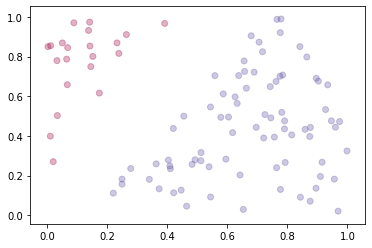

In [3]:
data = np.asarray(data)
X = data[:,:2]
Y = data[:,2]
plt.scatter(X[:,0],X[:,1],c=Y,cmap='Spectral',alpha=0.3);

In [4]:
def linearSVM(X, Y):
    N, columns = X.shape 
    Q = np.empty((N,N))
    #build Q matrix
    for m in range(N):
        for n in range(N):
            Q[m,n] = Y[m]*Y[n]*np.dot(X[m],X[n])
    #prep inputs for cvxopt QP-solver from docs
    P = cvxopt.matrix(Q)
    #minus summation alpha_n 
    q = cvxopt.matrix(-1*np.ones(N)) 
    #s.t. summation yn*alpha_n = 0
    A = cvxopt.matrix(Y,size=(1,N))
    b = cvxopt.matrix(0.0)
    #s.t. alpha_n >= 0 for all n, mult -1 since cvxopt constraint is Gx<=h
    G = cvxopt.matrix(np.diag(-np.ones(N)))
    h = cvxopt.matrix(np.zeros(N))
    #call QP-solver from cvxopt
    result = cvxopt.solvers.qp(P,q,G,h,A,b)
    alpha_forces = np.asarray(result['x']).T[0]
    #Retrieve Support Vector points by eliminating effectively zero alphas
    SupVecIdx = np.where(alpha_forces > 1e-3)[0]
    SupVecs = X[SupVecIdx]
    SupVecLabels = Y[SupVecIdx]
    SupVecAlphas = alpha_forces[SupVecIdx]
    #Get the W vector as LC of alphas, ys, xs for n in SV only
    W = np.sum([SupVecAlphas[n]*SupVecLabels[n]*SupVecs[n] for n in range(len(SupVecIdx))],axis=0)
    # b from comp slackness at optimality
    b = 1/SupVecLabels[0] - np.dot(W,SupVecs[0])
    return W, b, SupVecs, SupVecLabels, SupVecAlphas

In [5]:
linsep = linearSVM(X,Y)
W,b,SupVecs, SupVecLabels, SupVecAlphas = linsep[0], linsep[1], linsep[2], linsep[3], linsep[4]

     pcost       dcost       gap    pres   dres
 0: -2.0636e+01 -4.3905e+01  3e+02  2e+01  2e+00
 1: -2.2372e+01 -3.7202e+01  9e+01  5e+00  5e-01
 2: -2.3112e+01 -3.8857e+01  5e+01  2e+00  2e-01
 3: -2.8318e+01 -3.3963e+01  1e+01  4e-01  4e-02
 4: -3.2264e+01 -3.3927e+01  2e+00  1e-02  1e-03
 5: -3.3568e+01 -3.3764e+01  2e-01  1e-03  1e-04
 6: -3.3737e+01 -3.3739e+01  2e-03  1e-05  1e-06
 7: -3.3739e+01 -3.3739e+01  2e-05  1e-07  1e-08
 8: -3.3739e+01 -3.3739e+01  2e-07  1e-09  1e-10
Optimal solution found.


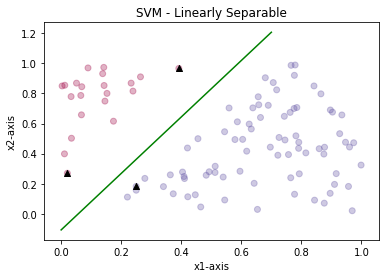

In [6]:
plt.scatter(X[:,0],X[:,1],c=Y,cmap='Spectral',alpha=0.3)
plt.scatter(SupVecs[:,0],SupVecs[:,1],marker='^',color='k',alpha=1.0); #support vectors
xx = np.linspace(0,0.7)
yy = (-W[0]/W[1])*xx + b
plt.plot(xx,yy,'g-'); #plot the SVM Hyperplane
plt.title('SVM - Linearly Separable')
plt.xlabel('x1-axis')
plt.ylabel('x2-axis');

In [7]:
#Support Vectors
for i in range(len(SupVecs)):
    print('Support Vector '+str(i+1)+': ',SupVecs[i])

Support Vector 1:  [0.24979414 0.18230306]
Support Vector 2:  [0.3917889  0.96675591]
Support Vector 3:  [0.02066458 0.27003158]


In [8]:
#Report the Equation:
print('W: ', W)
print('b: ', b)

W:  [ 7.25005616 -3.86188932]
b:  -0.10698729032462029


Equation:<br>
<br>
$b + W^{T} x = 0$
<br>
$-0.1069 + (7.25) \cdot X1 + (-3.86) \cdot X2 = 0$

### Part 1(b) Using non-linearly separable data

Using a kernel function of your choice along with the same Quadratic Programming solver, find the equation of a curve that separates the points in nonlinsep.txt. Report the kernel function you use as well as the support vectors.

In [9]:
nldata = pd.read_csv('nonlinsep.txt',header=None)
nldata.columns = ['x1','x2','label']
nldata.head()

,x1,x2,label
0,13.147033,-19.811823,1
1,10.245927,7.953735,1
2,-20.567695,8.684645,1
3,-13.584656,21.940365,1
4,-14.231219,8.576612,1


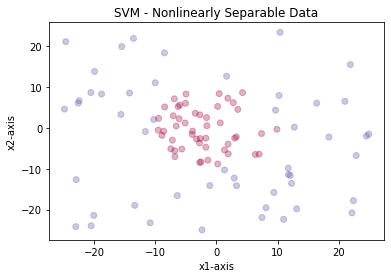

In [10]:
nldata = np.asarray(nldata)
X = nldata[:,:2]
Y = nldata[:,2]
plt.scatter(X[:,0],X[:,1],c=Y,cmap='Spectral',alpha=0.3)
plt.title('SVM - Nonlinearly Separable Data')
plt.xlabel('x1-axis')
plt.ylabel('x2-axis');

In [11]:
def PolynomKernel(Xm,Xn):
    dotproduct = (1+np.dot(Xm,Xn))**2
    return dotproduct
def nonlinearSVM(X,Y):
    N, columns = X.shape
    Q = np.empty((N,N))
    #build Q matrix
    for m in range(N):
        for n in range(N):
            #build Q matrix but with kernel function instead
            Q[m,n] = Y[m]*Y[n]*PolynomKernel(X[m],X[n])
    #prep inputs for cvxopt QP-solver
    P = cvxopt.matrix(Q)
    #minus summation alpha_n 
    q = cvxopt.matrix(-1*np.ones(N)) 
    #subject to summation yn*alpha_n = 0
    A = cvxopt.matrix(Y,size=(1,N))
    b = cvxopt.matrix(0.0)
    #s.t. alpha_n >= 0 for all n, mult -1 since cvxopt constraint is Gx<=h
    G = cvxopt.matrix(np.diag(-np.ones(N)))
    h = cvxopt.matrix(np.zeros(N))
    #call QP-solver from cvxopt
    result = cvxopt.solvers.qp(P,q,G,h,A,b)
    alpha_forces = np.asarray(result['x']).T[0]
    #Retrieve Support Vector points by eliminating effectively zero alphas
    SupVecIdx = np.where(alpha_forces > 1e-10)[0]
    SupVecs = X[SupVecIdx]
    SupVecLabels = Y[SupVecIdx]
    SupVecAlphas = alpha_forces[SupVecIdx]
    #Get the W vector as LC of alphas, ys, xs for n in SV only
    W = np.sum([SupVecAlphas[n]*SupVecLabels[n]*SupVecs[n] for n in range(len(SupVecIdx))],axis=0)
    # b from comp slackness at optimality
    b = SupVecLabels[0] - np.dot(W,SupVecs[0])
    return W,b,SupVecs, SupVecLabels, SupVecAlphas

In [12]:
nonlinsep = nonlinearSVM(X,Y)
nlW,nlb,nlSupVecs,nlSupVecLabels, nlSupVecAlphas = nonlinsep[0], nonlinsep[1], nonlinsep[2], nonlinsep[3],nonlinsep[4]

     pcost       dcost       gap    pres   dres
 0: -4.0666e+01 -1.0206e+02  5e+02  2e+01  3e+00
 1: -1.5924e+02 -2.2789e+02  3e+02  1e+01  1e+00
 2: -2.9280e+02 -3.6244e+02  3e+02  1e+01  1e+00
 3: -5.7710e+02 -6.0303e+02  4e+02  9e+00  1e+00
 4: -1.2873e+03 -1.2409e+03  5e+02  9e+00  1e+00
 5: -1.2647e+03 -1.0924e+03  7e+02  8e+00  9e-01
 6: -6.9076e+02 -4.0802e+02  1e+03  5e+00  6e-01
 7: -1.8688e+02 -2.9779e+01  4e+02  1e+00  2e-01
 8: -3.4731e+00 -5.2038e-02  1e+01  3e-02  4e-03
 9: -3.5053e-02 -3.8447e-02  1e-01  3e-04  3e-05
10: -2.1413e-02 -2.7448e-02  6e-03  8e-18  1e-13
11: -2.6166e-02 -2.6328e-02  2e-04  3e-18  1e-13
12: -2.6293e-02 -2.6295e-02  2e-06  6e-18  1e-13
13: -2.6295e-02 -2.6295e-02  2e-08  4e-18  1e-13
Optimal solution found.


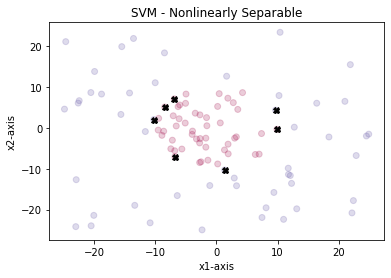

In [13]:
#Plot support Vectors
plt.scatter(X[:,0],X[:,1],c=Y,cmap='Spectral',alpha=0.2);
plt.plot(nlSupVecs[:,0],nlSupVecs[:,1],'Xk')
plt.title('SVM - Nonlinearly Separable')
plt.xlabel('x1-axis')
plt.ylabel('x2-axis');

In [14]:
for i in range(len(nlSupVecs)):
    print('Support Vector '+str(i+1)+': ', nlSupVecs[i])

Support Vector 1:  [-8.47422847  5.15621613]
Support Vector 2:  [-10.260969     2.07391791]
Support Vector 3:  [  1.3393313  -10.29098822]
Support Vector 4:  [9.67917724 4.3759541 ]
Support Vector 5:  [-6.90647562  7.14833849]
Support Vector 6:  [-6.80002274 -7.02384335]
Support Vector 7:  [ 9.90143538 -0.31483149]


Kernel Function:<br>
The Polynomial Kernel Function was used based on the example given in lecture: $K(x,x') = (1+x^{T}x')^{2}$

Equation of the curve:<br>
$\sum_{n \in SV} \alpha_{n} \cdot y_{n} \cdot K(x_{n},x) + b$

In [15]:
#where each of the alpha_n are:
print('alpha_n: \n',nlSupVecAlphas)
#each y_n is:
print('y_n: \n', nlSupVecLabels)
#and with b term:
print('b: \n', nlb)
print('x_n: \n', nlSupVecs)

alpha_n: 
 [1.25011960e-02 1.49903971e-02 6.64212765e-03 4.66214862e-03
 6.87420856e-10 7.40836604e-03 6.38511049e-03]
y_n: 
 [-1.  1.  1.  1. -1. -1. -1.]
b: 
 -0.9161376238787018
x_n: 
 [[ -8.47422847   5.15621613]
 [-10.260969     2.07391791]
 [  1.3393313  -10.29098822]
 [  9.67917724   4.3759541 ]
 [ -6.90647562   7.14833849]
 [ -6.80002274  -7.02384335]
 [  9.90143538  -0.31483149]]
